<a href="https://colab.research.google.com/github/clearlakerabbit/ME793_Project/blob/main/ME793_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
    import casadi
except:
    !pip install casadi
    import casadi

try:
    import do_mpc
except:
    !pip install do_mpc
    import do_mpc

try:
    import pybounds
except:
    #!pip install pybounds
    !pip install git+https://github.com/vanbreugel-lab/pybounds
    import pybounds

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.9/162.9 kB 4.2 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/do_mpc/sysid/__init__.py:15: UserWarning: The ONNX feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The ONNX feature is not available. Please install the full version of do-mpc to access this feature.')
/usr/local/lib/python3.12/dist-packages/do_mpc/opcua/__init__.py:14: UserWarning: The opcua feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The opcua feature is not available. Please install the full version of do-mpc to access this feature.')


  Cloning https://github.com/vanbreugel-lab/pybounds to /tmp/pip-req-build-xuf79m17
  Running command git clone --filter=blob:none --quiet https://github.com/vanbreugel-lab/pybounds /tmp/pip-req-build-xuf79m17
  Resolved https://github.com/vanbreugel-lab/pybounds to commit 96f12039ac9e1e3ef4381cd09a026f6bbf70ad5c
  Preparing metadata (setup.py) ... done
  Created wheel for pybounds: filename=pybounds-0.0.13-py3-none-any.whl size=19546 sha256=edaea1f16ddb3c1aab179b62bd8018aded5c10521737d6e60d2a729cbb4b2350
  Stored in directory: /tmp/pip-ephem-wheel-cache-4tiqbu2n/wheels/cb/f8/fb/ff1887f9a2f35c3edad7b1acb7da69437c1fd8d885a800578d
Successfully built pybounds


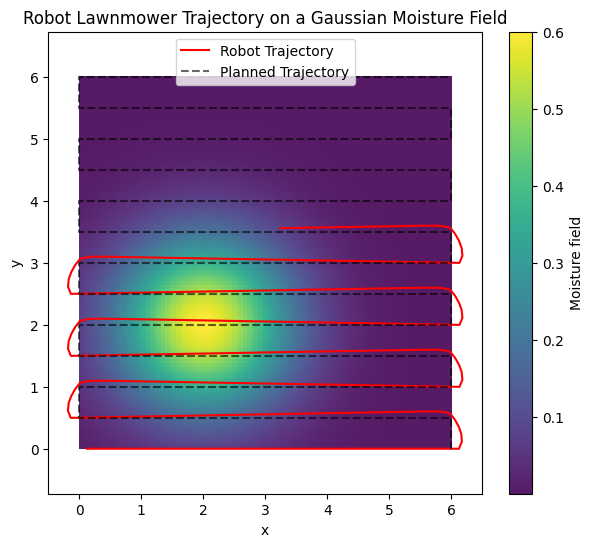

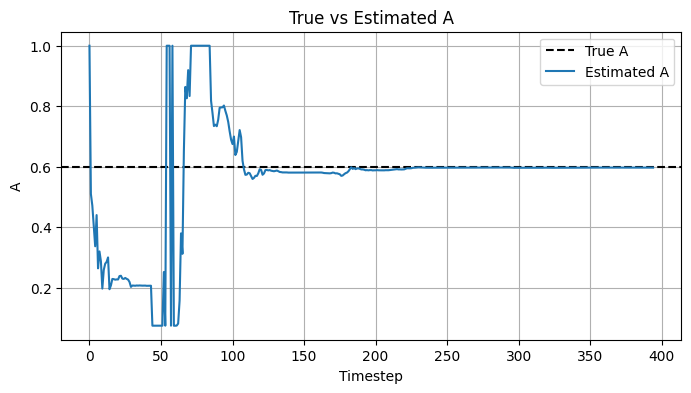

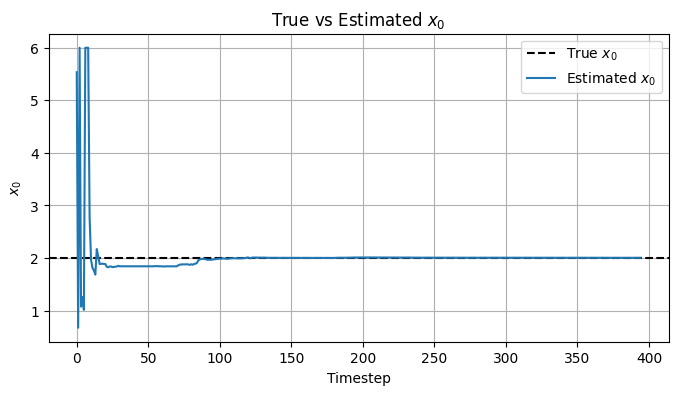

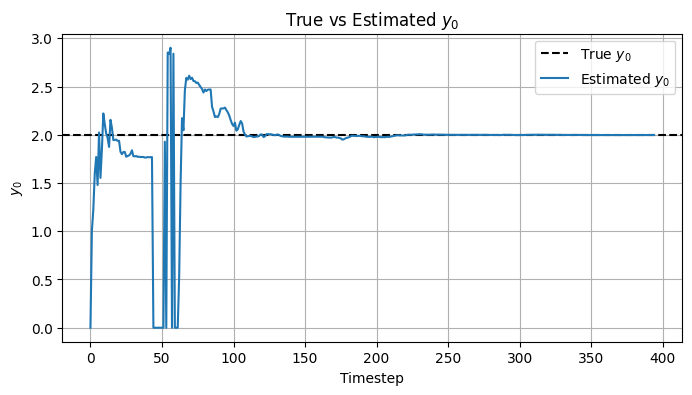

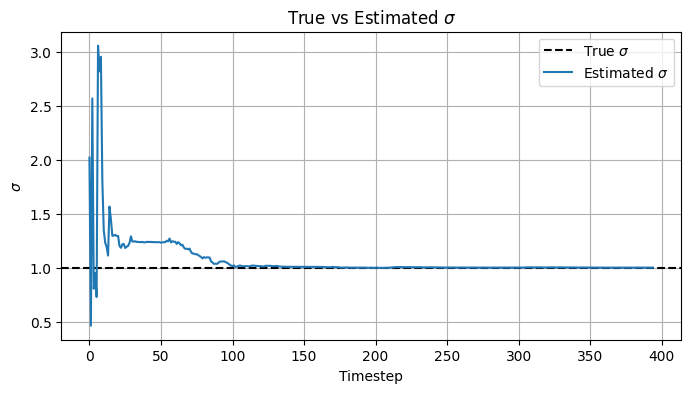

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
import os

# set seed for consistency
np.random.seed(1)

# folder for plots
plot_dir = "plots"
os.makedirs(plot_dir, exist_ok=True)

# true values of Gaussian parameters
A_true, x0_true, y0_true, sigma_true = 0.6, 2.0, 2.0, 1.0

# lawnmower trajectory implemented
field_width, field_height, strip_spacing = 6.0, 6.0, 0.5
dt, v_const = 0.5, 0.25

waypoints = []
y, direction = 0.0, 1
while y <= field_height:
    if direction == 1:
        waypoints.append((field_width, y))
    else:
        waypoints.append((0.0, y))
    y += strip_spacing
    direction *= -1
    if y <= field_height:
        waypoints.append((waypoints[-1][0], y))
waypoints = np.array(waypoints)

def controller(x_r, y_r, th, wp, v_nom=0.25):
    dx, dy = wp[0]-x_r, wp[1]-y_r
    target_angle = np.arctan2(dy, dx)
    angle_error = np.arctan2(np.sin(target_angle-th), np.cos(target_angle-th))
    v = v_nom
    omega = 1.5*angle_error
    return v, omega

# force model
def force_model(m, S):
    r = (1 - m) * (1 + 0.5 * S)
    return np.clip(r, 0, 1)
S = 0.3

# measurement noise for sim purposes
sigma_m, sigma_f = 0.02, 0.001

# simulating robot trajectory, assuming unicycle model
x_r, y_r, th = 0.0, 0.0, 0.0
x_hist, y_hist, th_hist = [], [], []
measurements = []
wp_idx = 0
# take 400 waypoints
for k in range(400):
    wp = waypoints[wp_idx]
    v, omega = controller(x_r, y_r, th, wp, v_const)
    x_r += v*np.cos(th)*dt
    y_r += v*np.sin(th)*dt
    th += omega*dt

    # measurements
    m_true = A_true*np.exp(-((x_r-x0_true)**2+(y_r-y0_true)**2)/(2*sigma_true**2))
    zm = m_true + np.random.normal(0,sigma_m)
    zf = force_model(m_true,S) + np.random.normal(0,sigma_f)
    measurements.append([x_r, y_r, zm, zf])
    x_hist.append(x_r); y_hist.append(y_r); th_hist.append(th)
    if np.linalg.norm(wp-np.array([x_r,y_r]))<0.1:
        if wp_idx < len(waypoints)-1:
            wp_idx += 1
        else:
            break
measurements = np.array(measurements)

# do least squares estimation
def residuals(params, data, S):
    A, x0, y0, sigma = params
    res = []
    for x_r, y_r, zm, zf in data:
        m_pred = A*np.exp(-((x_r-x0)**2+(y_r-y0)**2)/(2*sigma**2))
        f_pred = force_model(m_pred,S)
        res.append(zm - m_pred)
        res.append(zf - f_pred)
    return np.array(res)

estimates = []
params_guess = [0.5, 1.0, 1.0, 1.5]

for k in range(5, len(measurements)):  # start after 5 samples
    subset = measurements[:k+1]
    res = least_squares(residuals, x0=params_guess,
                        args=(subset,S),
                        bounds=([0,0,0,0.1],[1,6,6,5]))
    params_guess = res.x
    estimates.append(res.x)

estimates = np.array(estimates)

# visualzation of robot trajectory + planned trajectory + actual Gaussian plot (ground truth)
nx, ny = 100, 100
x = np.linspace(0, field_width, nx)
y = np.linspace(0, field_height, ny)
X, Y = np.meshgrid(x, y)

Z = A_true * np.exp(-((X - x0_true)**2 + (Y - y0_true)**2) / (2 * sigma_true**2))

plt.figure(figsize=(7,6))
plt.imshow(Z, extent=[0, field_width, 0, field_height],
           origin='lower', cmap='viridis', alpha=0.9)
plt.colorbar(label="Moisture field")

plt.plot(x_hist, y_hist, 'r-', lw=1.5, label='Robot Trajectory')
plt.plot(waypoints[:,0], waypoints[:,1], 'k--', alpha=0.6, label='Planned Trajectory')

plt.xlabel("x"); plt.ylabel("y")
plt.title("Robot Lawnmower Trajectory on a Gaussian Moisture Field")
plt.legend()
plt.axis("equal")
plt.grid(False)
plt.savefig(f"{plot_dir}/gaussian_field_trajectory.png", dpi=300)  # save figure
plt.show()

# plot parameter estimation + real parameters
labels = ["A", r"$x_0$", r"$y_0$", r"$\sigma$"]
true_vals = [A_true, x0_true, y0_true, sigma_true]

for i in range(4):
    plt.figure(figsize=(8,4))
    plt.axhline(true_vals[i], color='k', linestyle='--', label=f"True {labels[i]}")
    plt.plot(estimates[:,i], label=f"Estimated {labels[i]}")
    plt.xlabel("Timestep")
    plt.ylabel(labels[i])
    plt.title(f"True vs Estimated {labels[i]}")
    plt.legend()
    plt.grid()
    plt.savefig(f"{plot_dir}/param_estimate_{labels[i].replace('$','').replace('_','')}.png", dpi=300)  # save figure
    plt.show()


/tmp/ipython-input-4205579409.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.96])


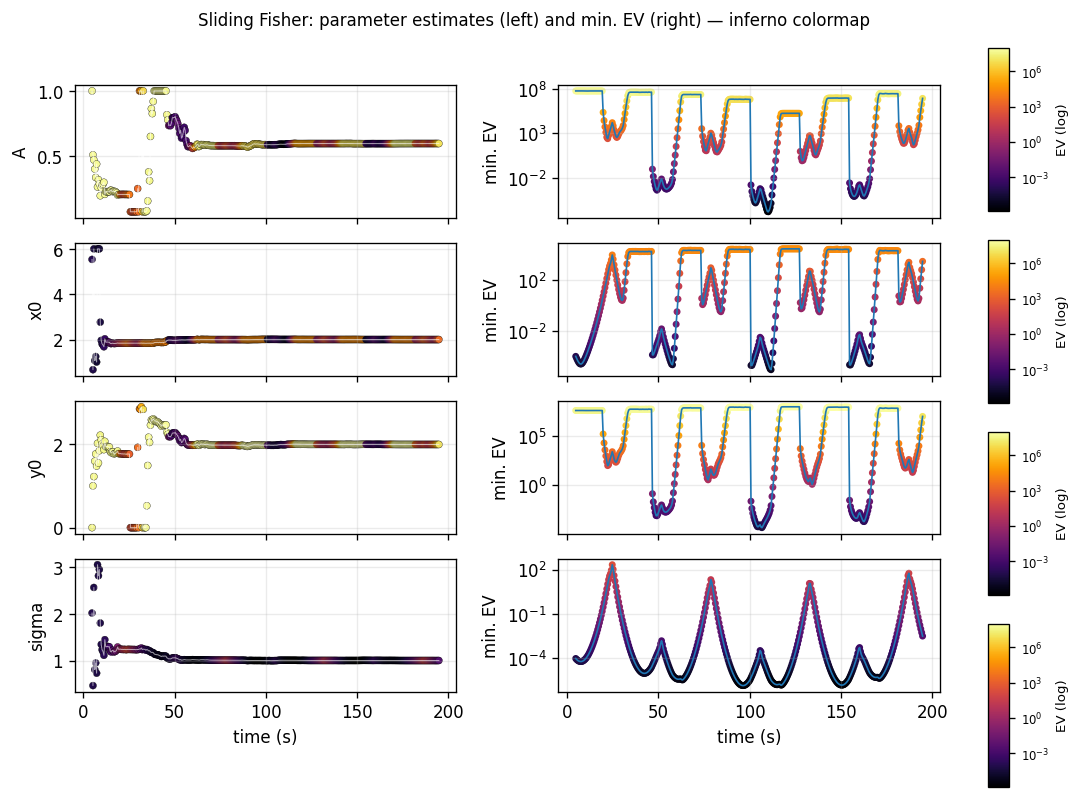

In [22]:
# # ---------------------------
# # Plot min error variances with 'inferno' colormap (two-column per-parameter)
# # Paste after EV_array, times_center computed above.
# # ---------------------------
# import matplotlib as mpl
# import matplotlib.pyplot as plt
# import numpy as np

# param_labels = ['A', 'x0', 'y0', 'sigma']
# n_params = len(param_labels)

# # Ensure EV_array and times_center exist
# # EV_array shape: (n_windows, 4) ; times_center shape: (n_windows,)
# if EV_array.ndim != 2 or EV_array.shape[1] != n_params:
#     raise RuntimeError("EV_array shape unexpected. Expected (n_windows, 4).")

# # Prepare parameter values to plot on left column:
# # If `estimates` exists, map its values to times_center approximately.
# # estimates length may differ from times_center; map by nearest-indexing.
# param_series_mapped = np.zeros((len(times_center), n_params))
# if 'estimates' in globals() and len(estimates) > 0:
#     # estimates shape: (N_estimates, 4) computed from incremental least-squares
#     # Map estimates indices to times_center by nearest index mapping
#     est_len = len(estimates)
#     # build a mapping from times_center index -> estimated index (clamped)
#     map_indices = np.round(np.linspace(0, est_len - 1, len(times_center))).astype(int)
#     for i in range(n_params):
#         param_series_mapped[:, i] = estimates[map_indices, i]
# else:
#     # fallback: use true params repeated across times_center
#     true_vals = [A_true, x0_true, y0_true, sigma_true]
#     for i in range(n_params):
#         param_series_mapped[:, i] = true_vals[i]

# # Determine color normalization from EVs (use global min/max across all params)
# ev_vals = EV_array.flatten()
# ev_vals = ev_vals[np.isfinite(ev_vals) & (ev_vals > 0)]
# if ev_vals.size == 0:
#     ev_min, ev_max = 1e-12, 1.0
# else:
#     ev_min, ev_max = ev_vals.min(), ev_vals.max()
# # avoid degenerate ranges
# ev_min = max(ev_min, 1e-12)
# if ev_max <= ev_min:
#     ev_max = ev_min * 1e3

# # Log normalization for color mapping
# cnorm = mpl.colors.LogNorm(vmin=ev_min, vmax=ev_max)
# cmap = plt.get_cmap('inferno')

# fig, axes = plt.subplots(n_params, 2, figsize=(9, n_params * 1.6), dpi=120, sharex=True)
# axes = np.atleast_2d(axes)

# for i, pname in enumerate(param_labels):
#     ax_left = axes[i, 0]
#     ax_right = axes[i, 1]

#     # Left: parameter value (mapped) colored by EV (use scatter + line)
#     cvals = EV_array[:, i]
#     sc = ax_left.scatter(times_center, param_series_mapped[:, i], c=cvals, cmap=cmap, norm=cnorm, s=18, edgecolors='k', linewidths=0.2)
#     ax_left.plot(times_center, param_series_mapped[:, i], color='white', linewidth=0.6, alpha=0.6)  # guide line
#     ax_left.set_ylabel(pname)
#     ax_left.grid(alpha=0.25)

#     # Right: EV vs time (log scale) colored by same map (we'll use a line with colored markers)
#     ax_right.set_yscale('log')
#     # plot EV line
#     ax_right.plot(times_center, EV_array[:, i], linewidth=1)
#     # overlay scatter colored by EV for visual consistency
#     ax_right.scatter(times_center, EV_array[:, i], c=EV_array[:, i], cmap=cmap, norm=cnorm, s=10)
#     ax_right.set_ylabel('min. EV')
#     ax_right.grid(which='both', alpha=0.25)

#     # colorbar per-row (right side of row)
#     cax = fig.add_axes([0.92, 0.72 - i*(1.0/n_params), 0.02, 1.0/n_params*0.85])  # manual axes for stacked colorbars
#     cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=cnorm, orientation='vertical')
#     cb.set_label('EV (log)', fontsize=8)
#     cb.ax.tick_params(labelsize=7)

# # X-label and layout
# for ax in axes[-1, :]:
#     ax.set_xlabel('time (s)')
# plt.suptitle('Sliding Fisher: parameter estimates (left) and min. EV (right) — inferno colormap', fontsize=10)
# plt.tight_layout(rect=[0, 0, 0.9, 0.96])
# plt.show()


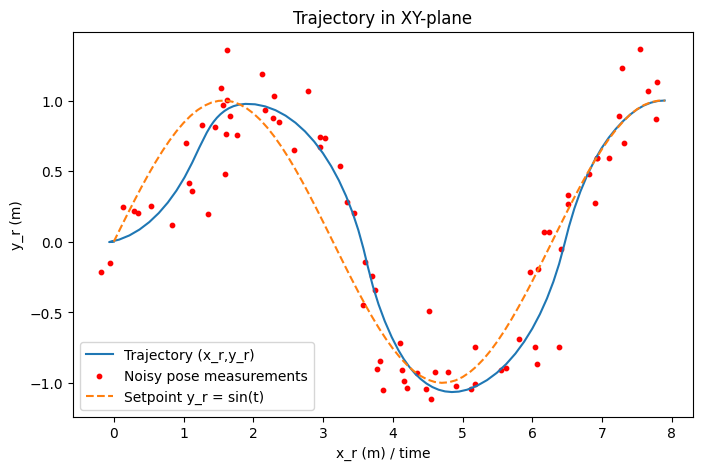

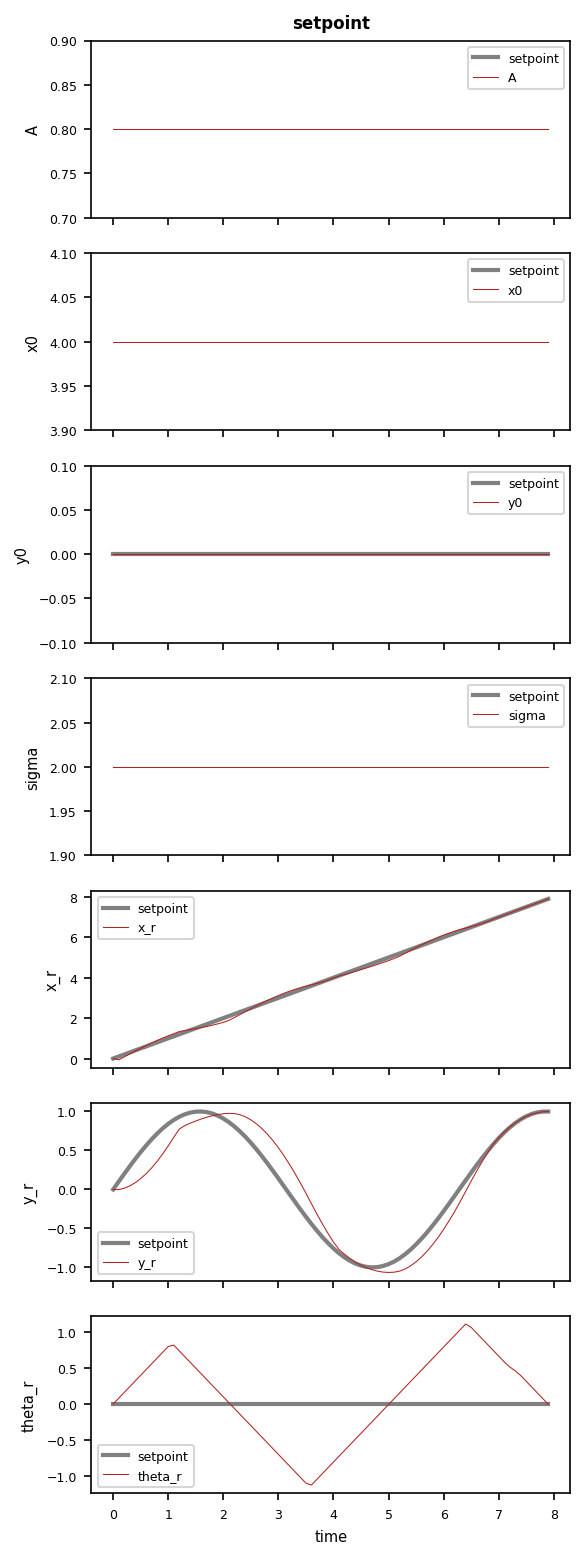

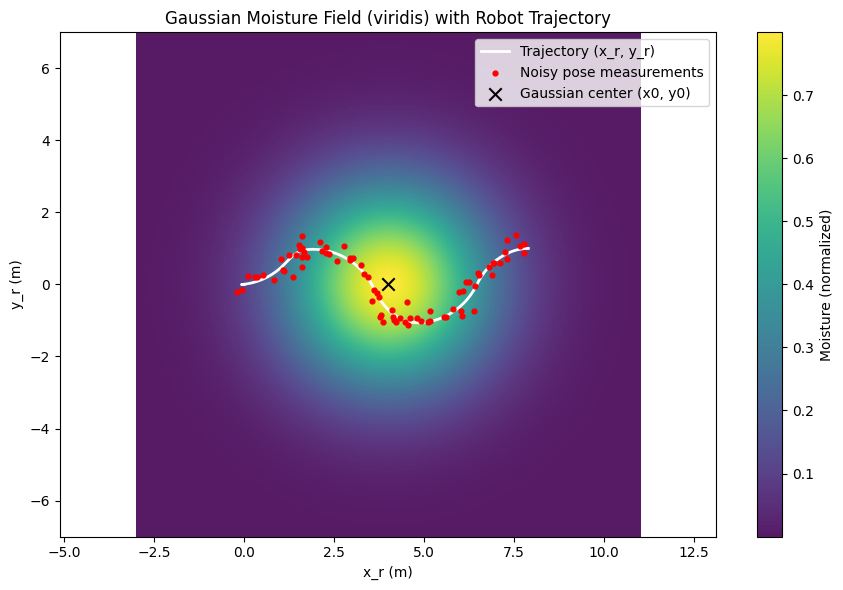

In [23]:
import pybounds
import numpy as np
import matplotlib.pyplot as plt

#parameters
params = dict(
    # Robot physical params
    m=20.0, kv=300.0, bv=20.0, Iz=1.0, kw=50.0, bw=2.0,
    # field parameters (real, for purposes of simulation)
    A_true=0.8, x0_true=4.0, y0_true=0.0, sigma_true=2.0,
    soil_type=1.0, # example scalar representing soil type
    force_alpha=500.0, # scaling for force model
    force_beta=200.0, # nonlinear term for force model
    # measurement noise (stddev)
    noise_pose_xy=0.2,
    noise_pose_theta=0.05,
    noise_moisture=0.02,
    noise_force=0.4
)

# dynamics
def f(x, u):
    v, w = u

    # unpack state
    A, x0, y0, sigma, x_r, y_r, theta_r = x

    # static field parameters
    dA = 0.0
    dx0 = 0.0
    dy0 = 0.0
    dsigma = 0.0

    # simple unicycle kinematics for robot pose
    dx_r = v * np.cos(theta_r)
    dy_r = v * np.sin(theta_r)
    dtheta = w

    return [dA, dx0, dy0, dsigma, dx_r, dy_r, dtheta]

# measurement model
def g_m_from_state(x):
    # Return moisture value m = Gaussian(A, x0, y0, sigma) evaluated at robot pose (x_r,y_r)
    A, x0, y0, sigma, x_r, y_r, theta_r = x
    sigma_eff = sigma if sigma > 1e-6 else 1e-6
    m_val = A * np.exp(-((x_r - x0)**2 + (y_r - y0)**2) / (2.0 * sigma_eff**2))
    return m_val

def force_model(m_local, soil_type=params['soil_type']):
    """
    Example nonlinear force model mapping moisture -> resistance.
    This is just a plausible nonlinear mapping (higher moisture -> lower resistance).
    F = alpha*(1 - m) + beta*(1 - m)^2 scaled by soil_type.
    """
    alpha = params['force_alpha']
    beta = params['force_beta']
    F = soil_type * (alpha * (1.0 - m_local) + beta * (1.0 - m_local)**2)
    return F

def h(x_vec, u_vec):
    """
    Measurement function returning:
      [x_r_noisy, y_r_noisy, theta_noisy, z_m (moisture noisy), z_f (force noisy)]
    """
    # unpack state
    A, x0, y0, sigma, x_r, y_r, theta_r = x_vec

    # pose measurements with additive Gaussian noise
    x_r_meas = x_r + np.random.normal(0.0, params['noise_pose_xy'])
    y_r_meas = y_r + np.random.normal(0.0, params['noise_pose_xy'])
    theta_meas = theta_r + np.random.normal(0.0, params['noise_pose_theta'])

    # environmental measurements
    m_local = g_m_from_state(x_vec)
    z_m = m_local + np.random.normal(0.0, params['noise_moisture'])

    # force measurement (nonlinear) + noise
    z_f = force_model(m_local) + np.random.normal(0.0, params['noise_force'])

    y_vec = [x_r_meas, y_r_meas, theta_meas, z_m, z_f]
    return y_vec

state_names = ['A', 'x0', 'y0', 'sigma', 'x_r', 'y_r', 'theta_r']
input_names = ['v', 'w']
measurement_names = ['x_r', 'y_r', 'theta_r', 'z_m', 'z_f']
dt = 0.1
tsim = np.arange(0, 8.0, step=dt)

# create simulator
simulator = pybounds.Simulator(f, h, dt=dt, state_names=state_names,
                               input_names=input_names, measurement_names=measurement_names,
                               mpc_horizon=10)

# true initial states
x0 = [
    params['A_true'],
    params['x0_true'],
    params['y0_true'],
    params['sigma_true'],
    0.0, # x_r initial
    0.0, # y_r initial
    0.0 # theta_r initial
]

# setpoint/time-varying params
setpoint = {
    'x_r': tsim,
    'y_r': np.sin(tsim),
}
simulator.update_dict(setpoint, name='setpoint')

# objective function
cost_x = (simulator.model.x['x_r'] - simulator.model.tvp['x_r_set']) ** 2
cost_y = (simulator.model.x['y_r'] - simulator.model.tvp['y_r_set']) ** 2
cost = cost_x + cost_y
simulator.mpc.set_objective(mterm=cost, lterm=cost)

# input penalty (small)
simulator.mpc.set_rterm(v=1e-4, w=1e-4)

# input bounds
simulator.mpc.bounds['upper', '_u', 'v'] = 1.5
simulator.mpc.bounds['lower', '_u', 'v'] = -1.5
simulator.mpc.bounds['upper', '_u', 'w'] = 0.8
simulator.mpc.bounds['lower', '_u', 'w'] = -0.8

# simulator
t_sim, x_sim, u_sim, y_sim = simulator.simulate(x0=x0, u=None, mpc=True, return_full_output=True)

# plot trajectory and measurements
plt.figure(figsize=(8, 5))
plt.plot(x_sim['x_r'], x_sim['y_r'], label='Trajectory (x_r,y_r)')
plt.scatter(y_sim['x_r'], y_sim['y_r'], color='red', s=10, label='Noisy pose measurements')
plt.plot(tsim, np.sin(tsim), '--', label='Setpoint y_r = sin(t)')
plt.xlabel('x_r (m) / time')
plt.ylabel('y_r (m)')
plt.title('Trajectory in XY-plane')
plt.legend()
simulator.plot('setpoint')
plt.tight_layout()
plt.show()

xr_traj = np.array(x_sim['x_r'])
yr_traj = np.array(x_sim['y_r'])

# choose padding so map nicely contains trajectory and Gaussian center
pad_x = 1.0
pad_y = 1.0

xmin = min(xr_traj.min(), params['x0_true'] - 3*params['sigma_true']) - pad_x
xmax = max(xr_traj.max(), params['x0_true'] + 3*params['sigma_true']) + pad_x
ymin = min(yr_traj.min(), params['y0_true'] - 3*params['sigma_true']) - pad_y
ymax = max(yr_traj.max(), params['y0_true'] + 3*params['sigma_true']) + pad_y

# grid for moisture field
nx, ny = 200, 200
x = np.linspace(xmin, xmax, nx)
y = np.linspace(ymin, ymax, ny)
X, Y = np.meshgrid(x, y)

# Gaussian moisture field (ground truth) using your params
A_true = params['A_true']
x0_true = params['x0_true']
y0_true = params['y0_true']
sigma_true = params['sigma_true']
Z = A_true * np.exp(-((X - x0_true)**2 + (Y - y0_true)**2) / (2 * sigma_true**2))

# start plotting
plt.figure(figsize=(9, 6))

# show moisture map first (so trajectory draws on top)
im = plt.imshow(Z,
                extent=[xmin, xmax, ymin, ymax],
                origin='lower',
                cmap='viridis',
                alpha=0.9,
                aspect='auto')

# plot planned setpoint path (if available as tvp)
try:
    # if you previously set a lawnmower path, plot it (optional)
    if 'x_r' in simulator.model.tvp and 'y_r' in simulator.model.tvp:
        plt.plot(simulator.model.tvp['x_r_set'], simulator.model.tvp['y_r_set'], 'k--', alpha=0.6, label='Setpoint path')
except Exception:
    pass

# robot trajectory and noisy pose measurements on top
plt.plot(xr_traj, yr_traj, color='white', linewidth=2, label='Trajectory (x_r, y_r)')
plt.scatter(y_sim['x_r'], y_sim['y_r'], color='red', s=12, label='Noisy pose measurements', zorder=5)
plt.scatter([x0_true], [y0_true], marker='x', color='black', s=80, label='Gaussian center (x0, y0)', zorder=6)

plt.colorbar(im, label='Moisture (normalized)')
plt.xlabel('x_r (m)')
plt.ylabel('y_r (m)')
plt.title('Gaussian Moisture Field (viridis) with Robot Trajectory')
plt.legend(loc='upper right')
plt.axis('equal')
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.tight_layout()
plt.show()

In [38]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# w: sliding window size (samples)
w = 6

measurement_noise_stds = {
    'x_r': params['noise_pose_xy'],
    'y_r': params['noise_pose_xy'],
    'theta_r': params['noise_pose_theta'],
    'z_m': params['noise_moisture'],
    'z_f': params['noise_force'],
}

# convert to variances for Fisher computation
measurement_noise_vars = {k: v**2 for k, v in measurement_noise_stds.items()}

# construct the Sliding Empirical Observability Matrix (SEOM)
SEOM = pybounds.SlidingEmpiricalObservabilityMatrix(simulator, t_sim, x_sim, u_sim, w=w, eps=1e-4)

# get list of observability matrices
O_sliding = SEOM.get_observability_matrix()
print(f"{len(O_sliding)} observability windows computed (w={w})")

# show columns (sensors x states x time-steps) available in the SEOM dataframe
print("Available measurement names:", SEOM.O_df_sliding[0].columns.tolist()[:20], "... (truncated)")

# compute Fisher information for the first sliding window
# FO = pybounds.FisherObservability(SEOM.O_df_sliding[0], measurement_noise_vars, lam=1e-8)
# F, F_inv, R = FO.get_fisher_information()
# print("Fisher information matrix (window 0) shape:", F.shape)
# print("Fisher inverse (approx) shape:", F_inv.shape)

o_sensors = measurement_names.copy()  # ['x_r', 'y_r', 'theta_r', 'z_m', 'z_f']

# states from system
o_states = state_names.copy()  # ['A','x0','y0','sigma','x_r','y_r','theta_r']

# time steps inside each window to evaluate (indices relative to window), must be <= w
window_size = w if w is not None else len(t_sim)
o_time_steps = np.arange(0, min(window_size, 6), step=1)  # first few time indices in each window

# build R for selected sensors
o_measurement_noise_vars = {key: measurement_noise_vars[key] for key in o_sensors}

# compute Sliding Fisher Observability across windows for chosen sensors/states/timesteps
SFO = pybounds.SlidingFisherObservability(
    SEOM.O_df_sliding,
    time=SEOM.t_sim,
    lam=1e-8,
    R=o_measurement_noise_vars,
    states=o_states,
    sensors=o_sensors,
    time_steps=o_time_steps,
    w=None
)


75 observability windows computed (w=6)
Available measurement names: ['A', 'x0', 'y0', 'sigma', 'x_r', 'y_r', 'theta_r'] ... (truncated)


/tmp/ipython-input-1186376958.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  EV_no_nan = EV_aligned.fillna(method='bfill').fillna(method='ffill')


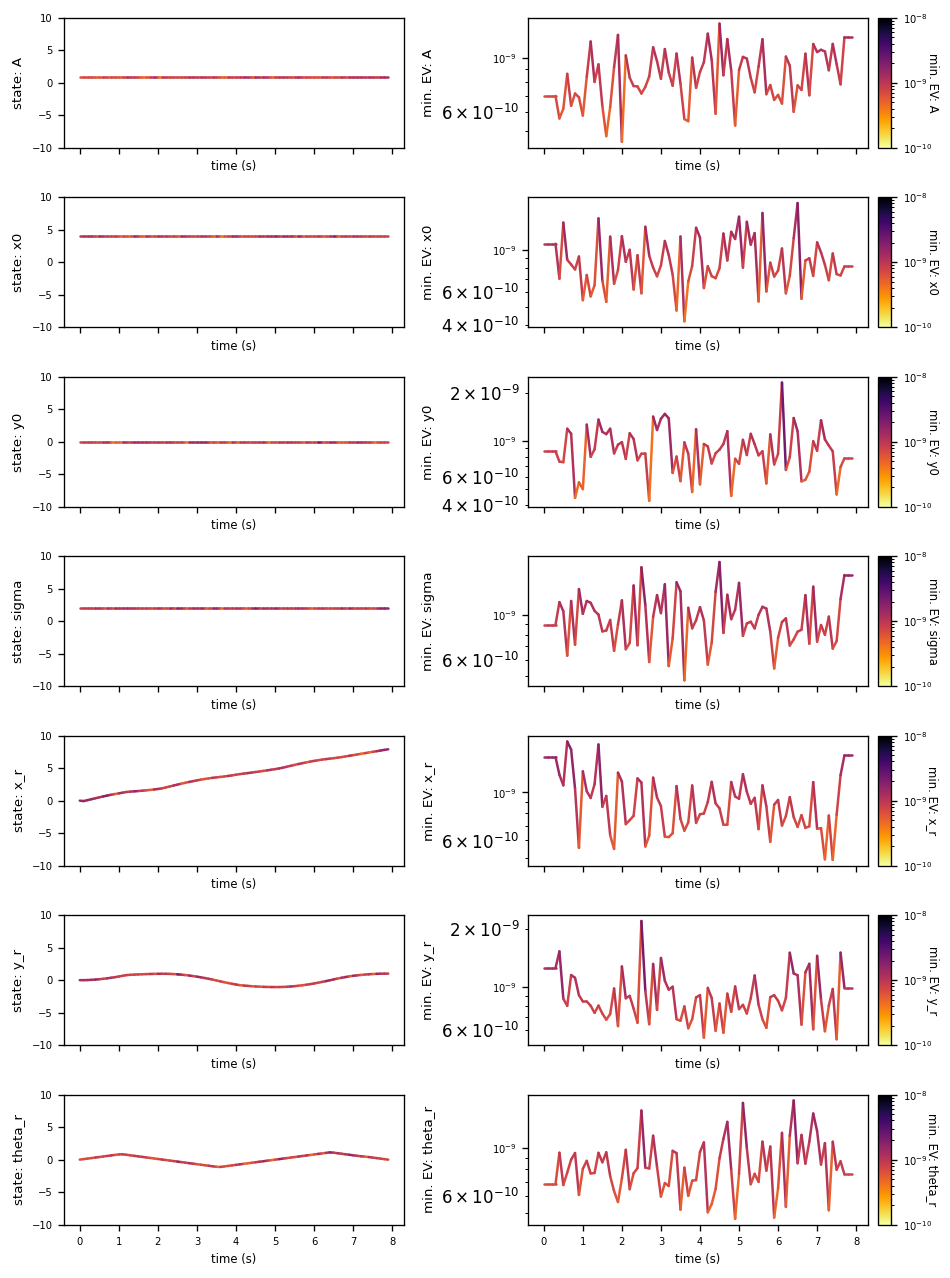

In [42]:
# pull out minimum error variance (aligned to window centers)
EV_aligned = SFO.get_minimum_error_variance()

EV_no_nan = EV_aligned.fillna(method='bfill').fillna(method='ffill')

x_sim_df = pd.DataFrame(x_sim)
u_sim_df = pd.DataFrame(u_sim)
y_sim_df = pd.DataFrame(y_sim)

states = list(SFO.FO[0].O.columns)
n_state = len(states)

fig, ax = plt.subplots(n_state, 2, figsize=(8, n_state*1.6), dpi=120, sharex=True)
ax = np.atleast_2d(ax)

cmap = 'inferno_r'
min_ev = np.nanmin(EV_no_nan.iloc[:, 2:].values)
max_ev = np.nanmax(EV_no_nan.iloc[:, 2:].values)

log_tick_low = int(np.floor(np.log10(min_ev)))
log_tick_high = int(np.ceil(np.log10(max_ev)))
cnorm = mpl.colors.LogNorm(vmin=10**log_tick_low, vmax=10**log_tick_high)

for n, state_name in enumerate(states):
    pybounds.colorline(SEOM.t_sim, x_sim_df[state_name].values, EV_no_nan[state_name].values,
                           ax=ax[n, 0], cmap=cmap, norm=cnorm)
    pybounds.colorline(SEOM.t_sim, EV_no_nan[state_name].values, EV_no_nan[state_name].values,
                           ax=ax[n, 1], cmap=cmap, norm=cnorm)
    # colorbar
    cax = ax[n, -1].inset_axes([1.03, 0.0, 0.04, 1.0])
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap), cax=cax,
                        ticks=np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))
    cbar.set_label('min. EV: ' + state_name, rotation=270, fontsize=7)
    cbar.ax.tick_params(labelsize=6)

    ax[n, 0].set_ylim(-10, 10)
    ax[n, 0].set_ylabel('state: ' + state_name, fontsize=8)
    ax[n, 1].set_yscale('log')
    ax[n, 1].set_ylabel('min. EV: ' + state_name, fontsize=8)

for a in ax.flat:
    a.tick_params(axis='both', labelsize=6)
    a.set_xlabel('time (s)', fontsize=7)
    offset = t_sim[-1] * 0.05
    a.set_xlim(-offset, t_sim[-1] + offset)

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.4)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

# median_evs = {s: np.nanmedian(EV_no_nan[s].values) for s in states}
# print("Median minimum error variance (per state):")
# for s, val in median_evs.items():
#     print(f"  {s}: {val:.3e}")